# RGBChem

RGBChem is a procedure for predicting the properties of chemical compounds using the conversion of chemical properties to RGB images.

In this Jupyter Notebook we present the main ideas of the whole workflow showing on a small database.

## Loading python files from github

In [ ]:
!pip -q install gitpython

In [ ]:
from git import Repo

repo_path = '/content/RGBChem'

repo_url = 'https://github.com/all2gos/RGBChem.git'

Repo.clone_from(repo_url, repo_path)

<git.repo.base.Repo '/content/RGBChem/.git'>

## Data Preparation

For the purpose of presenting a working demo, we will use a small dataset that is a fraction of the [qm9 database](https://www.nature.com/articles/sdata201422), which contains 133885 organic molecules with up to 9 heavy atoms (CONF). We will use only those compounds that contain up to 7 heavy atoms from this base. The dataset was prepared by us in advance.

In [ ]:
import pandas as pd

ds = pd.read_csv('/content/RGBChem/qm7_demo.csv')


In [ ]:
ds.drop(['cords','mulliken'],axis=1).head()

,Unnamed: 0,n_atoms,ID,A,B,C,Dipole moment,Isotropic Polarizability,Energy of HOMO,Energy of LUMO,...,Enthalphy at 298K,Free energy at 298K,Heat capacity at 298K,atom_type,Number_of_C,Number_of_H,Number_of_O,Number_of_F,Number_of_N,Sum_of_heavy_atoms
0,24,13,gdb_1049_24,7.53035,2.17416,1.70529,1.0339,56.25,-0.1935,0.0365,...,-344.461119,-344.500052,22.803,"['C', 'O', 'C', 'C', 'C', 'C', 'O', 'H', 'H', ...",5,6,2,0,0,7
1,29,19,gdb_1857_29,5.12440,1.90931,1.57139,0.1979,73.05,-0.2347,0.0280,...,-273.798509,-273.838115,28.317,"['C', 'C', 'C', 'C', 'C', 'C', 'C', 'H', 'H', ...",7,12,0,0,0,7
2,50,11,gdb_607_50,6.56461,2.98095,2.34689,4.0674,47.52,-0.2780,0.0249,...,-285.277655,-285.313705,20.749,"['O', 'C', 'C', 'C', 'C', 'N', 'H', 'H', 'H', ...",4,5,1,0,1,6
3,99,19,gdb_2296_99,7.75867,1.28533,1.17847,0.9237,68.69,-0.2500,0.0911,...,-310.888817,-310.930214,28.213,"['C', 'O', 'C', 'C', 'C', 'C', 'C', 'H', 'H', ...",6,12,1,0,0,7
4,119,12,gdb_859_119,7.26724,2.01738,1.57904,2.0191,51.69,-0.1714,0.0648,...,-360.527260,-360.565607,25.256,"['O', 'C', 'C', 'C', 'O', 'C', 'N', 'H', 'H', ...",4,5,2,0,1,7


### Image Creation

The whole procedure is based on the following concepts:

- We represent a molecule with $N$ atoms as a matrix of dimensions $(N+m)\times(N+m)$, where $m$ is some assumed margin that makes all generated images of the same dimension
- In cells where $i=j$ (i.e., on the diagonal of the matrix), we can put information about properties specific to individual atoms (e.g., atomic charge)
- In the cell where $i \neq j$ we include information describing the relationship between atom $i$ and $j$, for example, the Cartesian distance of these atoms
- This creates 3 matrices that contain 3 to 6 types of different information.
- We scale all the values in the matrices so that each has values in the range $0-255$.
- In this way, we obtain 3 matrices that are direct information about the scale of each color in the RGB system -> based on this we generate the corresponding images.


One important fact should be kept in mind: a translation or rotation of a molecule does not change its energy or any other property. Still, we can generate lots of images according to the given procedure for the same molecule. We decided to use this fact to augment the data and generate many different images for the same molecule. However in this demo we do not do that.

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
import random

from RGBChem.scripts.matrix_function import *
from RGBChem.scripts.params import *


def making_rgb_numerically(row, bo, ds):
    #print(row)

    cords = eval(ds.cords.iloc[row])
    n_atoms = ds.n_atoms.iloc[row]
    atom_types = eval(ds.atom_type.iloc[row])

    r =  distance(cords, n_atoms)
    g =  coulomb_matrix(cords, n_atoms, atom_types, diagonal = COULOMB_DIAGONAL)
    b =  bond_order(distance(cords, n_atoms), atom_types, bo)

    #scaling
    r_max= 9.47
    r_min= 0.0
    g_max= 44.61
    g_min= 0.0
    b_max= 2.69
    b_min= 0.0

    r = (255*(r - r_min) / (r_max - r_min)).astype(int)
    g = (255*(g - g_min) / (g_max - g_min)).astype(int)
    b = (255*(b - b_min) / (b_max - b_min)).astype(int)

    return r,g,b

def making_rgb(mat, id, label):

  combined = np.transpose(np.array((mat[0],mat[1],mat[2])),(1,2,0))

  img = np.array(combined, dtype=np.uint8)

  pImg = Image.fromarray(img, mode='RGB')

  pImg.save(f"{PATH}/{label}/{id}.png")

def creating_images(start, end, bo, ds, split=0.1, step=1, verbose = False):
    os.makedirs(f'{PATH}/{TRAIN_DIR_NAME}', exist_ok=True)
    os.makedirs(f'{PATH}/{TEST_DIR_NAME}', exist_ok = True)

    for chem in range(start, end+1, step):

        if random.randint(1,int(1/split)) == int(1/split):
            making_rgb(making_rgb_numerically(chem, bo, ds), ds.ID.iloc[chem], label = TEST_DIR_NAME)
            if verbose == True:
              print(f"{chem} goes to test set")
        else:

            making_rgb(making_rgb_numerically(chem, bo, ds), ds.ID.iloc[chem], label=TRAIN_DIR_NAME)

For one matrix, it is necessary to specify parameters from ReaxFF. So far, the most accessible and efficient way is to paste them into a dictionary directly in notebook.

In [ ]:
        bo = {'CC':[-0.075,6.8316,-0.1,9.2605,-0.4591,37.7369,1.3825,1.1359,1.2104],
            'OO':[-0.1302,6.2919,-0.1239,7.6487,-0.1244,29.6439,1.2477,1.0863,0.9088],
            'CF': [-0.0953,5.7786,-0.25,15,-0.5,35,1.6,1.3144,-1],
            'OF':[-0.1,10,-0.25,15,-0.5,45,-1,-1,-1],
            'FF':[-0.1442,5.2741,-0.25,15,-0.35,25,1.162,-1,-1], #rpi changed to -1 from -0.1
            'CN':[-0.115,5.8717,-0.2103,7.4487,-0.2709,29.9009,1.9263,1.4778,1.1446],
            'ON':[-0.1937,5.214,-0.2175,7.0255,-0.4462,34.9336,1.9531,1.3018,1.0984],
            'FN':[-0.1,10,-0.25,15,-0.5,45,-1,-1,-1],
            'NN':[-0.1791,5.8008,-0.205,9.7308,-0.1,19.085,1.6157,1.2558,1.0439],
            'CH':[-0.05,6.8315,0,0,0,6,1.4,1.1203,-1],
            'HH':[-0.0593,4.8358,0,0,0,6,0.7853,-1,-1], #rpi and rpi changed to -1 from -0.1
            'CO':[-0.1463,5.2913,-0.3174,7.0303,-0.1613,10.8851,1.8523,1.2775,1.1342],
            'HO':[-0.0657,5.0451,0,0,0,6,1.68,0.9013,-1],
            'HN':[-0.0395,7.2218,0,0,0,6,2.3,1.0156,-1],
            'HF':[-0.0794,6.1403,-0.2,15,-0.2,16,-1,-1,-1],
            'FC': [-0.0953,5.7786,-0.25,15,-0.5,35,1.6,1.3144,-1],
            'FO':[-0.1,10,-0.25,15,-0.5,45,-1,-1,-1],
            'NC':[-0.115,5.8717,-0.2103,7.4487,-0.2709,29.9009,1.9263,1.4778,1.1446],
            'NO':[-0.1937,5.214,-0.2175,7.0255,-0.4462,34.9336,1.9531,1.3018,1.0984],
            'NF':[-0.1,10,-0.25,15,-0.5,45,-1,-1,-1],
            'HC':[-0.05,6.8315,0,0,0,6,1.4,1.1203,-1],
            'OC':[-0.1463,5.2913,-0.3174,7.0303,-0.1613,10.8851,1.8523,1.2775,1.1342],
            'OH':[-0.0657,5.0451,0,0,0,6,1.68,0.9013,-1],
            'NH':[-0.0395,7.2218,0,0,0,6,2.3,1.0156,-1],
            'FH':[-0.0794,6.1403,-0.2,15,-0.2,16,-1,-1,-1]}

In [ ]:
creating_images(0, len(ds)-1, bo, ds,  0.1, 1) #creating all files

In [ ]:
def calibration(ds, d, bo):
  data = []
  c = []
  start = random.randint(0,5) #to avoid too long execution
  for compound in range(start, len(ds), int(len(ds)/d)): #step != 1 to avoid too long execution

    try:
      data.append(making_rgb_numerically(compound, bo, ds))
    except ValueError:
      print(ds.ID.iloc[compound])
      c.append(ds.ID.iloc[compound])

  max_values = []
  min_values = []

  for matrices_group in zip(*data):
      max_group = np.max([np.max(matrix) for matrix in matrices_group])
      min_group = np.min([np.min(matrix) for matrix in matrices_group])
      max_values.append(max_group)
      min_values.append(min_group)

  print("r_max=", max_values[0])
  print("r_min=", min_values[0])
  print("g_max=", max_values[1])
  print("g_min=", min_values[1])
  print("b_max=", max_values[2])
  print("b_min=", min_values[2])

#we can check that the values in each matrix are within the range of 0-255 and change the calibration if necessary
#in general, it is best to first generate images without any calibration and then scale them accordingly
calibration(ds, len(ds[:1000]), bo)


r_max= 255
r_min= 0
g_max= 254
g_min= 0
b_max= 255
b_min= 0


## Check the received images

In [ ]:
from fastai.vision.all import *

def get_list(path):
    l = []
    for plik in os.listdir(path):
        if os.path.isfile(os.path.join(path, plik)):
            l.append(plik)
    return l

def get_x(r): return f"{path}/{r['ID']}.png"
def get_y(r): return float(r[PREDICTED_VALUE])



path = f'{PATH}/{TRAIN_DIR_NAME}'
get_image_files = get_list(path)


In [ ]:
f = os.listdir(f"{PATH}/{TRAIN_DIR_NAME}")
f = [x[:-4] for x in f]

filtered = ds[ds.ID.isin(f)]
print(f'{len(filtered)} out of {len(ds)} samples were selected')


3565 out of 3993 samples were selected


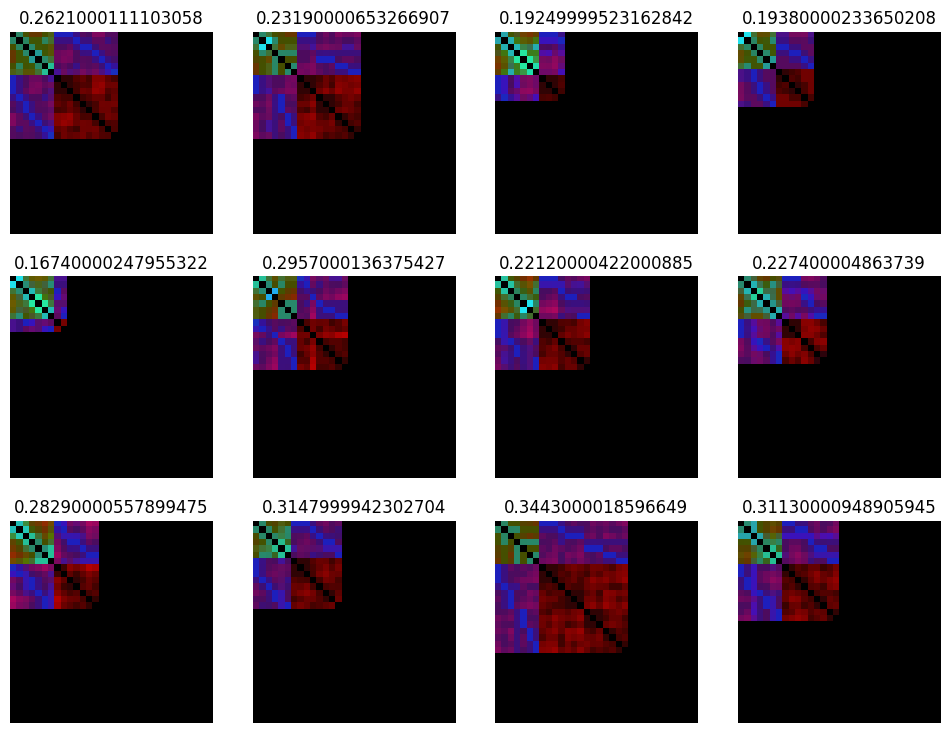

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, RegressionBlock),
                   get_x=get_x, get_y=get_y,
                   splitter=RandomSplitter(valid_pct=0.1, seed=42)).dataloaders(filtered)

dblock.show_batch(max_n=12)

### Individual Colors

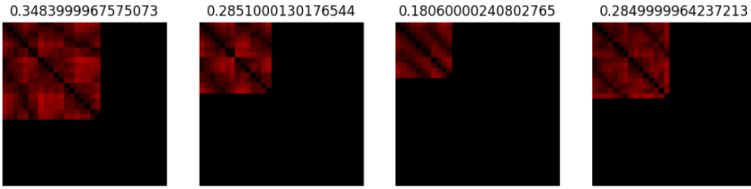

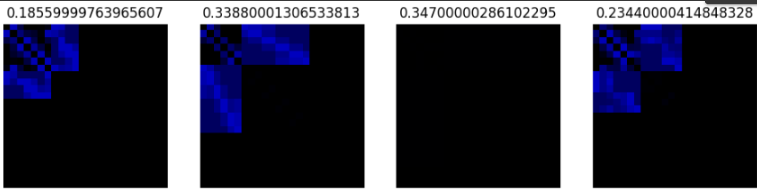

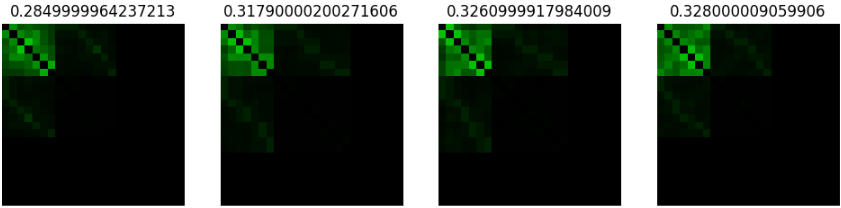

## Training the Model

For the demo purpose, we choose HOMO-LUMO Gap as the property to predict. And because of the simplicity and transparency of the fastai library, we use that library in this demo to carry out the machine learning workflow. We choose a very simple architecture for learning, which takes very little time to train.

In the standard workflow, we will still use the fastai library to generate data batches, but we will build the model using clear PyTorch to have more control over the training process.

In [ ]:
learn = vision_learner(dblock, resnet18, metrics=mae)
learn.fine_tune(32) #~2 minutes training on T4 GPU

epoch,train_loss,valid_loss,mae,time
0,2.889959,0.886009,0.720549,00:05


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,mae,time
0,1.951116,0.336743,0.420461,00:04
1,1.657264,0.312546,0.351367,00:04
2,1.416322,0.198669,0.315103,00:05
3,1.169995,0.166614,0.271747,00:04
4,0.981443,0.142981,0.255559,00:05
5,0.778724,0.103888,0.228173,00:04
6,0.556384,0.072731,0.178791,00:04
7,0.370289,0.035249,0.131063,00:05
8,0.251151,0.019258,0.093841,00:04
9,0.159679,0.011504,0.084377,00:05


In [ ]:
err = []
test_files = os.listdir(f"{PATH}/{TEST_DIR_NAME}")

for idx in range(len(test_files[:400])):
    num, _, probs = learn.predict(PILImage.create(f'{PATH}/{TEST_DIR_NAME}/{test_files[idx]}'))
    actual = ds[PREDICTED_VALUE].loc[ds.ID == test_files[idx][:-4]].values[0]
    err.append(np.abs(num-float(actual)))

print(f"Average error on test files is {sum(err)/len(err)*27211} meV")


Average error on test files is [852.90586602] meV


In [ ]:
err = []
train_files = os.listdir(f"{PATH}/{TRAIN_DIR_NAME}")

for idx in range(len(train_files[:400])):
    num, _, probs = learn.predict(PILImage.create(f'{PATH}/{TRAIN_DIR_NAME}/{train_files[idx]}'))
    actual = ds[PREDICTED_VALUE].loc[ds.ID == train_files[idx][:-4]].values[0]
    err.append(np.abs(num-float(actual)))

print(f"Average error on train files is {sum(err)/len(err)*27211} meV")

Average error on train files is [731.46693454] meV


As can be seen: the accuracy of the model is not very high, but it should be remembered here that the aim here was not to create an optimal model, but only to show the workflow. Currently our best model using this procedure achieved an average accuracy of less than 0.3 eV on the test set.